<center>

## ***Company-based Capstone Project***
#### **Team ID		: C24-MR01**

Team Member	: 

(ML) M002D4KY2877 - Auvarifqi Putra Diandra

(ML) M010D4KY3370 - Rafi Madani

(ML) M002D4KY2625 - Iskandar Muda Rizky Parlambang

(MD) A010D4KY4202 - Muhammad Adryan Haska Putra

(MD) A297D4KX4551 - Vena Feranica

(CC) C002D4KY1032 - Muhammad Naufal

(CC) C459D4KY0090 - Jamaludin Ahmad Rifai



---

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as scp
import plotly.express as px
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import polyfit
from datetime import datetime, timedelta
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, precision_score, \
    recall_score, classification_report, \
    accuracy_score, f1_score, silhouette_samples, silhouette_score
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB, CategoricalNB, MultinomialNB
from sklearn.datasets import make_classification

from rake_nltk import Rake
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from numpy import where
import os
import warnings
import tensorflow as tf
from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [86]:
data_path = './data'
movies_ratings = pd.read_csv(f"{data_path}/ratings_small.csv")
movies_ratings.head(10)

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205
5,1,1263,2.0,1260759151
6,1,1287,2.0,1260759187
7,1,1293,2.0,1260759148
8,1,1339,3.5,1260759125
9,1,1343,2.0,1260759131


In [87]:
movies_ratings.describe()

,userId,movieId,rating,timestamp
count,100004.000000,100004.000000,100004.000000,1.000040e+05
mean,347.011310,12548.664363,3.543608,1.129639e+09
std,195.163838,26369.198969,1.058064,1.916858e+08
min,1.000000,1.000000,0.500000,7.896520e+08
25%,182.000000,1028.000000,3.000000,9.658478e+08
50%,367.000000,2406.500000,4.000000,1.110422e+09
75%,520.000000,5418.000000,4.000000,1.296192e+09
max,671.000000,163949.000000,5.000000,1.476641e+09


In [88]:
movies_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100004 entries, 0 to 100003
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100004 non-null  int64  
 1   movieId    100004 non-null  int64  
 2   rating     100004 non-null  float64
 3   timestamp  100004 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [89]:
movies_ratings.shape

(100004, 4)

In [90]:
user_rating_df = movies_ratings.pivot(index='userId', columns='movieId', values='rating')
user_rating_df.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
norm_user_rating_df = user_rating_df.fillna(0) / 5.0
trX = norm_user_rating_df.values
trX[0:5]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0.8, ..., 0. , 0. , 0. ]])

In [92]:
hiddenUnits = 20
visibleUnits =  len(user_rating_df.columns)

vb = tf.Variable(tf.zeros([visibleUnits]), tf.float32) #Number of unique movies
hb = tf.Variable(tf.zeros([hiddenUnits]), tf.float32) #Number of features we're going to learn
W = tf.Variable(tf.zeros([visibleUnits, hiddenUnits]), tf.float32)

In [93]:
v0 = tf.zeros([visibleUnits], tf.float32)
#testing to see if the matrix product works
tf.matmul([v0], W)

<tf.Tensor: shape=(1, 20), dtype=float32, numpy=
array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.]], dtype=float32)>

In [94]:
#Phase 1: Input Processing
#defining a function to return only the generated hidden states 
def hidden_layer(v0_state, W, hb):
    h0_prob = tf.nn.sigmoid(tf.matmul([v0_state], W) + hb)  #probabilities of the hidden units
    h0_state = tf.nn.relu(tf.sign(h0_prob - tf.random.uniform(tf.shape(h0_prob)))) #sample_h_given_batch_X
    return h0_state

#printing output of zeros input
h0 = hidden_layer(v0, W, hb)
print("first 15 hidden states: ", h0[0][0:15])

def reconstructed_output(h0_state, W, vb):
    v1_prob = tf.nn.sigmoid(tf.matmul(h0_state, tf.transpose(W)) + vb) 
    v1_state = tf.nn.relu(tf.sign(v1_prob - tf.random.uniform(tf.shape(v1_prob)))) #sample_v_given_h
    return v1_state[0]


v1 = reconstructed_output(h0, W, vb)
print("hidden state shape: ", h0.shape)
print("v0 state shape:  ", v0.shape)
print("v1 state shape:  ", v1.shape)

first 15 hidden states:  tf.Tensor([0. 0. 1. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0.], shape=(15,), dtype=float32)
hidden state shape:  (1, 20)
v0 state shape:   (9066,)
v1 state shape:   (9066,)


In [95]:
def error(v0_state, v1_state):
    return tf.reduce_mean(tf.square(v0_state - v1_state))

err = tf.reduce_mean(tf.square(v0 - v1))
print("error" , err.numpy())

error 0.49724245


Epoch: 1 batch #: 0  of 1 sample #: 499 reconstruction error: 0.031254
Epoch: 1 batch #: 1  of 1 sample #: 170 reconstruction error: 0.014367
Epoch: 2 batch #: 0  of 1 sample #: 499 reconstruction error: 0.036196
Epoch: 2 batch #: 1  of 1 sample #: 170 reconstruction error: 0.014587
Epoch: 3 batch #: 0  of 1 sample #: 499 reconstruction error: 0.035313
Epoch: 3 batch #: 1  of 1 sample #: 170 reconstruction error: 0.014610
Epoch: 4 batch #: 0  of 1 sample #: 499 reconstruction error: 0.034519
Epoch: 4 batch #: 1  of 1 sample #: 170 reconstruction error: 0.013573
Epoch: 5 batch #: 0  of 1 sample #: 499 reconstruction error: 0.030261
Epoch: 5 batch #: 1  of 1 sample #: 170 reconstruction error: 0.013727


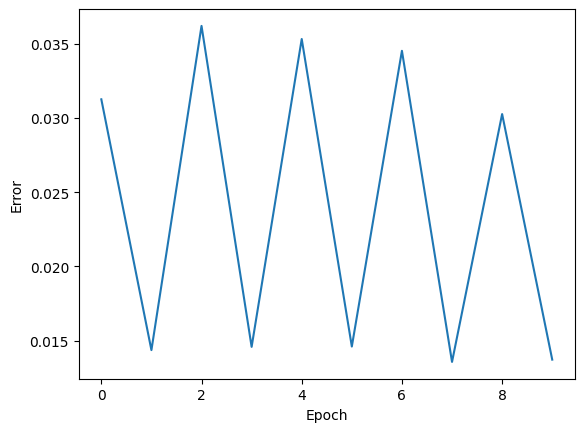

In [110]:
epochs = 5
batchsize = 500
errors = []
weights = []
K=1 #Number of time to run Contrastive divergence (method used to calculate the gradient (the slope representing the relationship between a network’s weights and its error)
alpha = 0.0001 #Learning Rate (0.1 to 0.0001) to reach minimized loss

#creating datasets
train_ds = \
    tf.data.Dataset.from_tensor_slices((np.float32(trX))).batch(batchsize)



#for i in range(epochs):
#    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
#        batch = trX[start:end]
#        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
#        prv_w = cur_w
#        prv_vb = cur_vb
#        prv_hb = cur_hb
#    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_hb}))
#    print (errors[-1])
v0_state=v0
for epoch in range(epochs):
    batch_number = 0
    for batch_x in train_ds:

        for i_sample in range(len(batch_x)):           
            for k in range(K):
                v0_state = batch_x[i_sample]
                h0_state = hidden_layer(v0_state, W, hb)
                v1_state = reconstructed_output(h0_state, W, vb)
                h1_state = hidden_layer(v1_state, W, hb)

                delta_W = tf.matmul(tf.transpose([v0_state]), h0_state) - tf.matmul(tf.transpose([v1_state]), h1_state)
                W = W + alpha * delta_W

                vb = vb + alpha * tf.reduce_mean(v0_state - v1_state, 0)
                hb = hb + alpha * tf.reduce_mean(h0_state - h1_state, 0) 

                v0_state = v1_state

            if i_sample == len(batch_x)-1:
                err = error(batch_x[i_sample], v1_state)
                errors.append(err)
                weights.append(W)
                print ( 'Epoch: %d' % (epoch + 1), 
                       "batch #: %i " % batch_number, "of %i" % (len(trX)/batchsize), 
                       "sample #: %i" % i_sample,
                       'reconstruction error: %f' % err)
        batch_number += 1




plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

In [111]:
mock_user_id = 215

In [112]:
#Selecting the input user
#inputUser = trX[mock_user_id-1].reshape(1, -1)

inputUser = tf.convert_to_tensor(trX[mock_user_id-1],"float32")
v0 = inputUser

print(v0)
v0.shape

tf.Tensor([0.6 0.  0.  ... 0.  0.  0. ], shape=(9066,), dtype=float32)


TensorShape([9066])

In [113]:
v0test = tf.zeros([visibleUnits], tf.float32)
v0test.shape

TensorShape([9066])

In [114]:
#Feeding in the user and reconstructing the input

hh0 = tf.nn.sigmoid(tf.matmul([v0], W) + hb)

vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)

rec = vv1

tf.maximum(rec,1)
for i in vv1:
    print(i)

tf.Tensor(
[1.8650809e-01 5.0061854e-04 1.8586803e-02 ... 6.0189393e-04 1.8500446e-03
 9.9595833e-05], shape=(9066,), dtype=float32)


In [115]:
unique_movie_ids = movies_ratings[['movieId']].drop_duplicates()

In [116]:
scored_movies_df_mock = unique_movie_ids[unique_movie_ids['movieId'].isin(user_rating_df.columns)]
scored_movies_df_mock = scored_movies_df_mock.assign(RecommendationScore = rec[0])
scored_movies_df_mock.sort_values(["RecommendationScore"], ascending=False).head(20)

,movieId,RecommendationScore
773,2108,0.753828
1146,909,0.727702
1600,3182,0.676132
1559,3004,0.644148
109,595,0.546840
921,3396,0.489588
260,2005,0.466889
296,2263,0.459226
1562,3007,0.455654
1574,3081,0.429187
